# Dogs vs. Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [47]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import skimage

In [33]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

## Функции загрузки данных

In [65]:
import cv2
import random
class augmentator:
    def __init__(self):
        self.modes=["gaussian","localvar","poisson","salt","pepper","s&p","speckle",None]


    def rotate(self, image, angle=90, scale=1.0):
        w = image.shape[1]
        h = image.shape[0]
        #rotate matrix
        M = cv2.getRotationMatrix2D((w/2,h/2), angle, scale)
        #rotate
        image = cv2.warpAffine(image,M,(w,h))
        return image

    def flip(self, image, vflip=False, hflip=False):
        if hflip or vflip:
            if hflip and vflip:
                c = -1
            else:
                c = 0 if vflip else 1
            image = cv2.flip(image, flipCode=c)
        return image 
    
    def add_noise(self, image, mode=0):
        return skimage.util.random_noise(image, mode=self.modes[mode])
    
    def augment(self, image, typ): 
        img = image.copy()
        if(typ == 1):
            return self.flip(img, vflip=(randrange(2) == 1), hflip=(randrange(2) == 1))
        elif(typ == 2):
            return self.rotate(img, randrange(36)*10)
        elif(typ == 3):
            return self.add_noise(img, randrange(len(self.modes)))
        else:
            return img
aug = augmentator()

In [66]:
import re
from random import shuffle
from glob import glob

train_files = glob('../input/train/*.jpg')
test_files = glob('../input/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    img = aug.augment(img, randrange(4))
    array = img_to_array(img)
    return preprocess_input(array)  # предобработка для VGG16

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=32):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if re.match('.*/dog\.\d', path) else 0. for path in files[i:j]])
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

In [67]:
train_files[:10]

['../input/train\\cat.0.jpg',
 '../input/train\\cat.1.jpg',
 '../input/train\\cat.10.jpg',
 '../input/train\\cat.100.jpg',
 '../input/train\\cat.1000.jpg',
 '../input/train\\cat.10000.jpg',
 '../input/train\\cat.10001.jpg',
 '../input/train\\cat.10002.jpg',
 '../input/train\\cat.10003.jpg',
 '../input/train\\cat.10004.jpg']

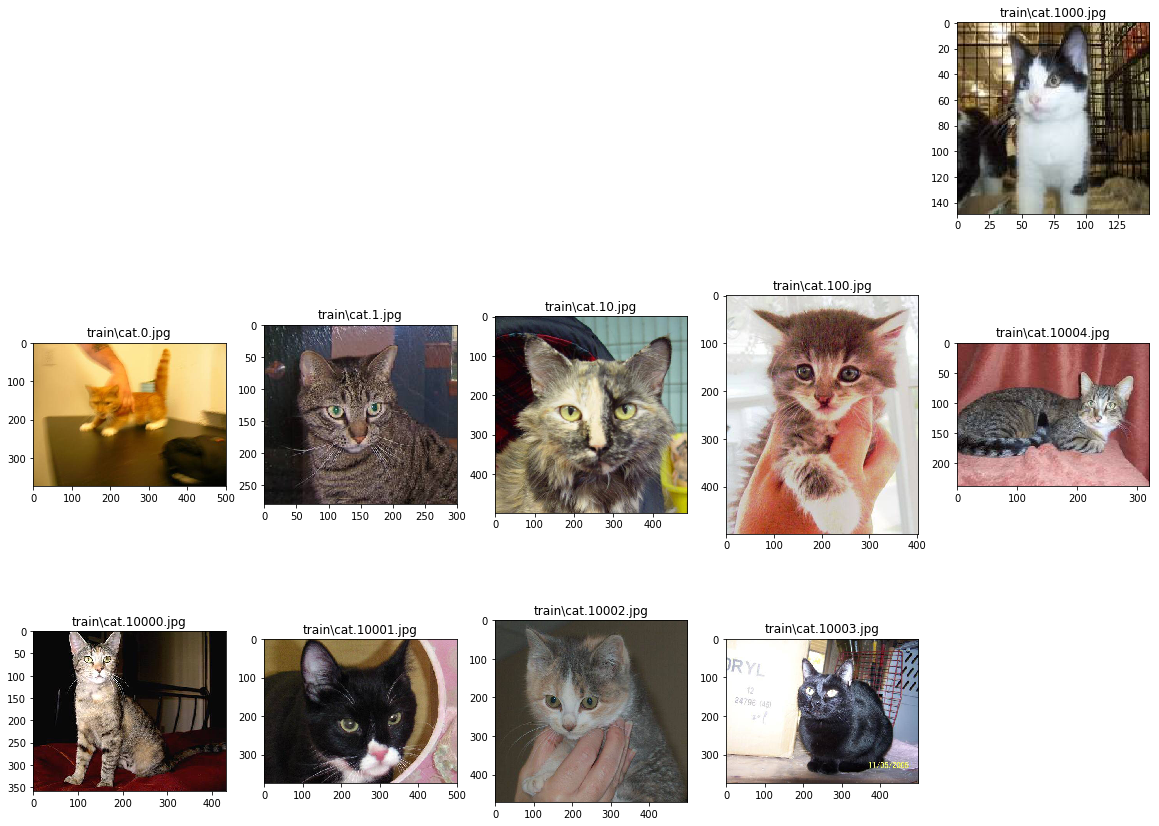

In [68]:
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path.split('/')[-1]);

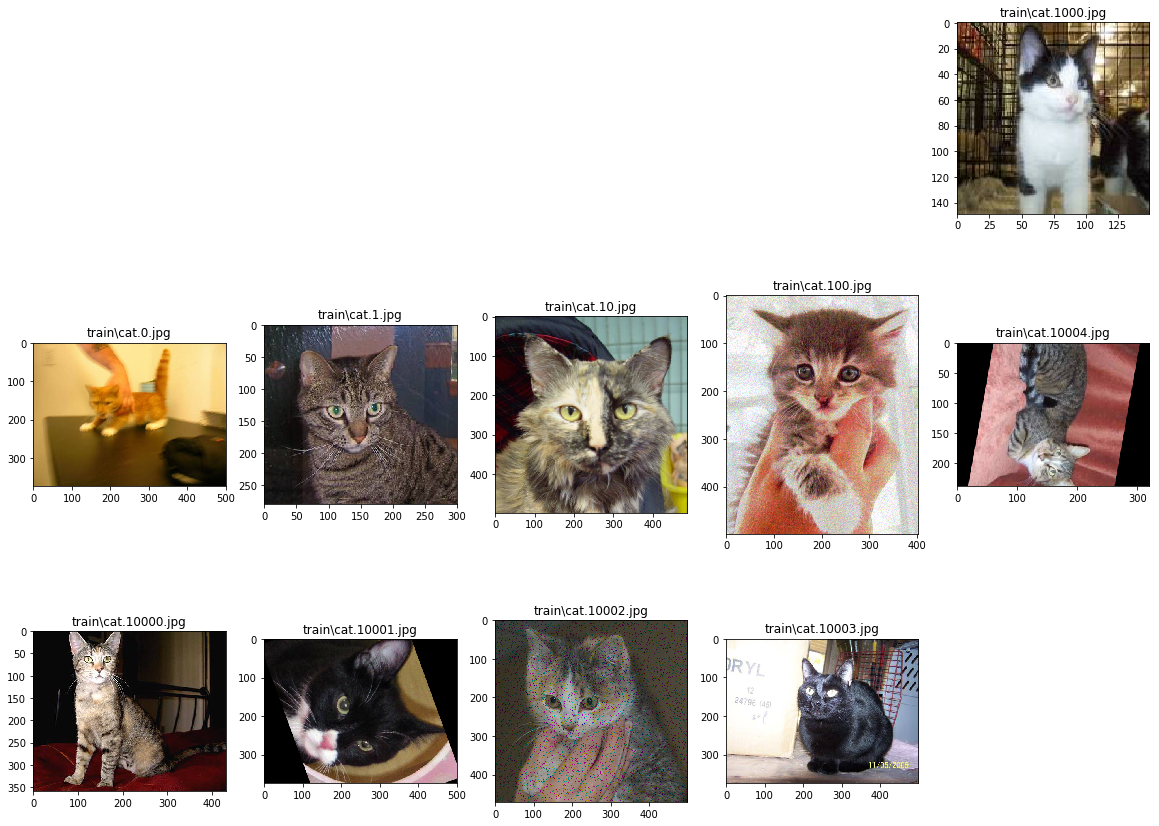

In [69]:
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(aug.augment(plt.imread(path), randrange(4)));
    subplot.set_title('%s' % path.split('/')[-1]);

## Загружаем предобученную модель

In [70]:
# base_model -  объект класса keras.models.Model (Functional Model)
base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

W0716 19:42:05.997480 16324 deprecation.py:506] From d:\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [71]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

In [72]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Добавляем полносвязный слой

In [73]:
x = base_model.layers[-1].output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1,  # один выход
                activation='sigmoid',  # функция активации  
                kernel_regularizer=keras.regularizers.l1(1e-4))(x)
model = Model(inputs=base_model.input, outputs=x)

## Выводим архитектуру модели

In [74]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Компилируем модель и запускаем обучение

In [83]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

W0716 19:01:02.285134 160176 deprecation.py:323] From d:\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
shuffle(train_files)  # перемешиваем обучающую выборку

train_val_split = 100  # число изображений в валидационной выборке

validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))

# запускаем процесс обучения
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=10,  # число вызовов генератора за эпоху
        epochs=100,  # число эпох обучения
        validation_data=validation_data)

Epoch 1/100
10/10 [==============================] - 58s 6s/step - loss: 0.9384 - acc: 0.9500 - val_loss: 0.0189 - val_acc: 1.0000
Epoch 2/100
10/10 [==============================] - 50s 5s/step - loss: 0.0191 - acc: 1.0000 - val_loss: 0.0192 - val_acc: 1.0000
Epoch 3/100
10/10 [==============================] - 49s 5s/step - loss: 0.0192 - acc: 1.0000 - val_loss: 0.0191 - val_acc: 1.0000
Epoch 4/100
10/10 [==============================] - 48s 5s/step - loss: 0.0191 - acc: 1.0000 - val_loss: 0.0190 - val_acc: 1.0000
Epoch 5/100
10/10 [==============================] - 47s 5s/step - loss: 0.0189 - acc: 1.0000 - val_loss: 0.0188 - val_acc: 1.0000
Epoch 6/100
10/10 [==============================] - 47s 5s/step - loss: 0.0187 - acc: 1.0000 - val_loss: 0.0186 - val_acc: 1.0000
Epoch 7/100
10/10 [==============================] - 48s 5s/step - loss: 0.0185 - acc: 1.0000 - val_loss: 0.0184 - val_acc: 1.0000
Epoch 8/100
 2/10 [=====>........................] - ETA: 30s - loss: 0.0184 - acc:

In [ ]:
model.save('cats-dogs-vgg16.hdf5')

## Предсказания на проверочной выборке

In [ ]:
pred = model.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500)

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(test_files[80:][:10], pred[80:][:10]), 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%.3f' % score);

## Готовим данные для сабмита

In [ ]:
with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, pred):
        dst.write('%s,%f\n' % (re.search('(\d+)', path).group(0), score))

In [ ]:
# LogLoss = 1.04979